In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from random import shuffle, seed
from glob import glob
import os

# Global variables

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reading dataset

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soroushmehraban","key":"ead0a55ee025b71704cd8ce9a236c86a"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [6]:
!kaggle datasets download -d tongpython/cat-and-dog

 92% 201M/218M [00:00<00:00, 229MB/s]
100% 218M/218M [00:00<00:00, 237MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [8]:
train_data_dir = 'training_set/training_set/'
test_data_dir = 'test_set/test_set/'

In [9]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(f"{folder}/cats/*.jpg")
        dogs = glob(f"{folder}/dogs/*.jpg")
        self.fpaths = cats + dogs
        
        # Randomize
        shuffle(self.fpaths)
        self.targets = [fpath.split(os.sep)[-1].startswith('dog') for fpath in self.fpaths] # dog = 1
    
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(),  torch.tensor([target]).float().to(device)

In [10]:
data = CatsDogs(train_data_dir)
im, label = data[200]

1.0


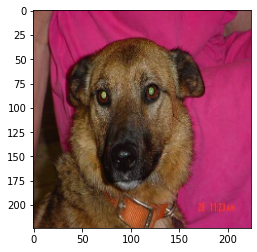

In [11]:
plt.imshow(im.permute(1, 2, 0).cpu())
print(label.item())

# Define model, loss function, and optimizer

In [12]:
def conv_layer(in_channels, out_channels, kernel_size, stride=1, batch_norm=True):
    if batch_norm:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

In [13]:
def get_model(batch_norm=True):
    model = nn.Sequential(
        conv_layer(3, 64, 3, 1, batch_norm),
        conv_layer(64, 512, 3, 1, batch_norm),
        conv_layer(512, 512, 3, 1, batch_norm),
        conv_layer(512, 512, 3, 1, batch_norm),
        conv_layer(512, 512, 3, 1, batch_norm),
        conv_layer(512, 512, 3, 1, batch_norm),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    ).to(device)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_function, optimizer

In [14]:
model, loss_function, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

# Functions

In [15]:
def get_data():
    train = CatsDogs(train_data_dir)
    train_dataloader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(test_data_dir)
    val_dataloder= DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return train_dataloader, val_dataloder

In [16]:
def train_batch(x, y, model, optimizer, loss_function):
    model.train()
    prediction = model(x)
    batch_loss = loss_function(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [17]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [18]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_function(prediction, y)
    return val_loss.item()

# Train the model for 5 epochs

In [19]:
train_dataloader, val_dataloader = get_data()
model, loss_function, optimizer = get_model()

In [20]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_dataloader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4


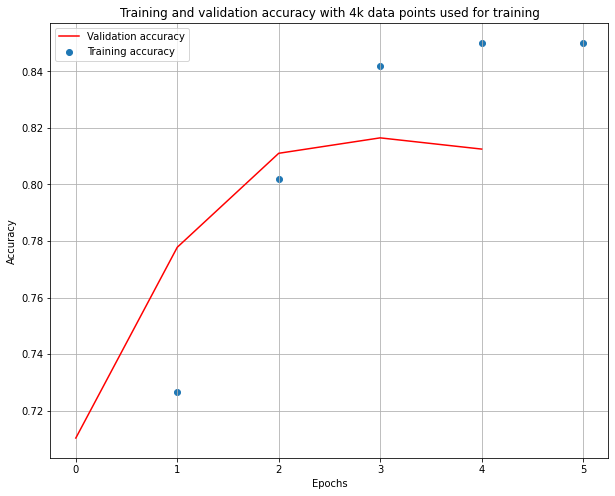

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

epochs = [i for i in range(1, 6)]

# Add data to ax
ax.scatter(x=epochs,
            y=train_accuracies)
ax.plot(val_accuracies, color='red')

# Customize ax
ax.set(title= "Training and validation accuracy with 4k data points used for training",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax
ax.legend(['Validation accuracy', 'Training accuracy'])

# Configure the grid lines
ax.grid('on');

# Train the model for 5 epochs (without batch normomalization)

In [22]:
train_dataloader, val_dataloader = get_data()
model, loss_function, optimizer = get_model(batch_norm=False)

In [23]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_dataloader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4


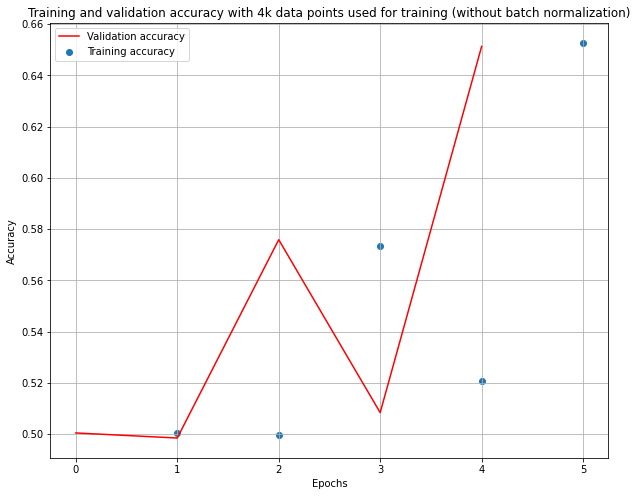

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

epochs = [i for i in range(1, 6)]

# Add data to ax
ax.scatter(x=epochs,
            y=train_accuracies)
ax.plot(val_accuracies, color='red')

# Customize ax
ax.set(title= "Training and validation accuracy with 4k data points used for training (without batch normalization)",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax
ax.legend(['Validation accuracy', 'Training accuracy'])

# Configure the grid lines
ax.grid('on');

# Training with fewer images

In [25]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(f"{folder}/cats/*.jpg")
        dogs = glob(f"{folder}/dogs/*.jpg")
        self.fpaths = cats[:500] + dogs[:500]
        
        # Randomize
        shuffle(self.fpaths)
        self.targets = [fpath.split(os.sep)[-1].startswith('dog') for fpath in self.fpaths] # dog = 1
    
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(),  torch.tensor([target]).float().to(device)

In [26]:
train_dataloader, val_dataloader = get_data()
model, loss_function, optimizer = get_model()

In [27]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"Current epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for batch in train_dataloader:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_function)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for batch in train_dataloader:
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for batch in val_dataloader:
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

Current epoch: 0
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4


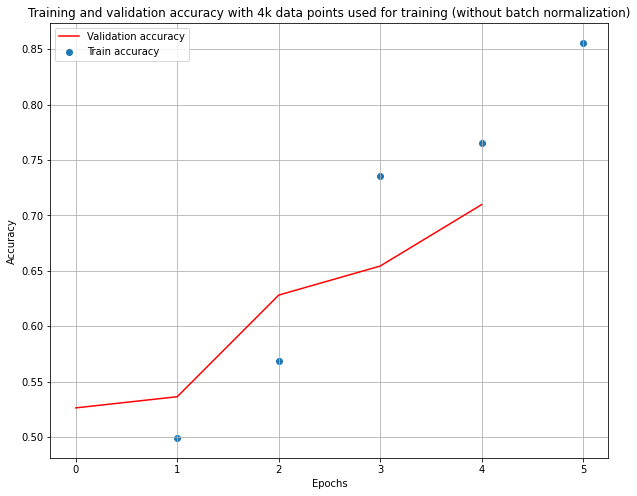

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

epochs = [i for i in range(1, 6)]

# Add data to ax
ax.scatter(x=epochs,
            y=train_accuracies)
ax.plot(val_accuracies, color='red')

# Customize ax
ax.set(title= "Training and validation accuracy with 4k data points used for training (without batch normalization)",
        ylabel= "Accuracy",
        xlabel= "Epochs")

# Add legend to ax
ax.legend(['Validation accuracy', 'Train accuracy'])

# Configure the grid lines
ax.grid('on');